In [91]:
# Import modules
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Welch's t-test
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [92]:
# new stimulus blocks
new_stimuli_imagery = pd.read_csv('../no_buffer_compare/data_blocks/new_stim_analysis/df_imagery_analysis.csv')
new_stimuli_perception = pd.read_csv('../no_buffer_compare/data_blocks/new_stim_analysis/df_perception_analysis.csv')

# no buffer blocks
no_buffer_imagery = pd.read_csv('../no_buffer_compare/data_blocks/no_buffer_analysis/df_imagery_analysis.csv')
no_buffer_perception = pd.read_csv('../no_buffer_compare/data_blocks/no_buffer_analysis/df_perception_analysis.csv')

new_stimuli_imagery.shape, new_stimuli_perception.shape, no_buffer_imagery.shape, no_buffer_perception.shape

((2175, 15), (1427, 15), (270, 15), (180, 15))

(0.0, 10.0)

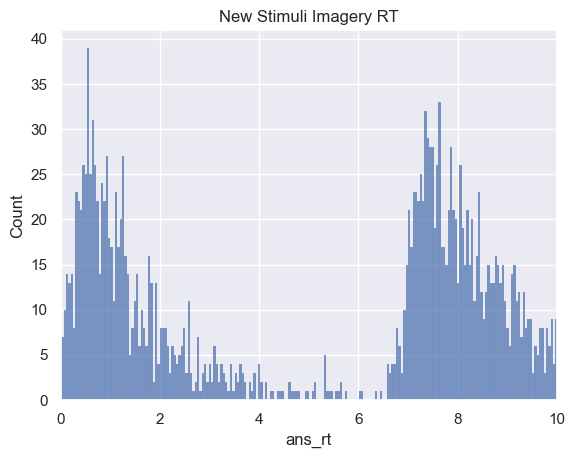

In [93]:
sns.set(style="darkgrid")
sns.histplot(data=new_stimuli_imagery, x="ans_rt", bins = 1000)
plt.title('New Stimuli Imagery RT')
plt.xlim(0, 10)

(0.0, 10.0)

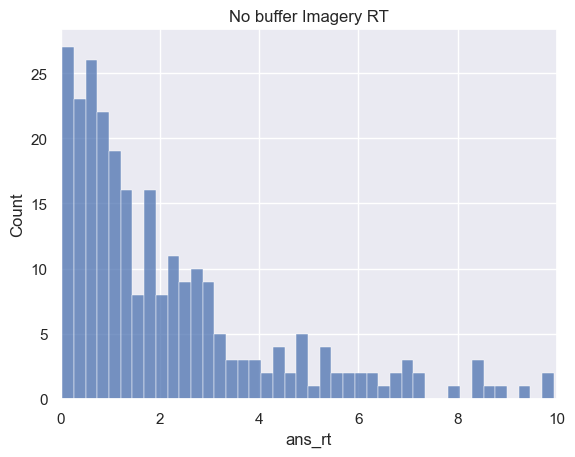

In [94]:
sns.set(style="darkgrid")
sns.histplot(data=no_buffer_imagery, x="ans_rt", bins=100)
plt.title('No buffer Imagery RT')
plt.xlim(0, 10)

In [95]:
def after_139(participant_id):
    id = participant_id[1:4]
    if int(id) >= 139 and int(id) <= 155:
        return True
    else:
        return False

    
def new_stimuli_df_split(df):
    df['after_139'] = df.apply(lambda x: after_139(x['participant']), axis=1)
    df_after_139 = df[df['after_139'] == True]
    df_before_139 = df[df['after_139'] == False]
    # drop 'after_139' col
    df_after_139.drop('after_139', axis=1, inplace=True)
    df_before_139.drop('after_139', axis=1, inplace=True)
    return df_before_139, df_after_139

df_before139_imagery, df_after139_imagery = new_stimuli_df_split(new_stimuli_imagery)
df_before139_perception, df_after139_perception = new_stimuli_df_split(new_stimuli_perception)

### deal with df_after139 problem

In [96]:
def correct_after139_df_rt(df):
    for index, row in df.iterrows():
        if row['ans_rt'] > 6.5:
            df.loc[index, 'ans_rt'] = row['ans_rt'] - 6.5
        else: 
            df.loc[index, 'ans_rt'] = np.nan
    # drop nan in ans_rt
    df_no_na = df.dropna(subset=['ans_rt'], inplace=False)
    print('Number of rows with nan in ans_rt: ', df.shape[0] - df_no_na.shape[0])
    return df

def correct_before139_df_rt(df):
    for index, row in df.iterrows():
        df.loc[index, 'ans_rt'] = row['ans_rt'] + 0.5
    return df

In [97]:
df_after139_perception = correct_after139_df_rt(df_after139_perception)
df_after139_imagery = correct_after139_df_rt(df_after139_imagery)

df_before139_imagery = correct_before139_df_rt(df_before139_imagery)
df_before139_perception = correct_before139_df_rt(df_before139_perception)

Number of rows with nan in ans_rt:  4
Number of rows with nan in ans_rt:  2


In [98]:
df_before139_imagery['IorP'] = 'Imagery'
df_before139_perception['IorP'] = 'Perception'
df_after139_imagery['IorP'] = 'Imagery'
df_after139_perception['IorP'] = 'Perception'
no_buffer_imagery['IorP'] = 'Imagery'
no_buffer_perception['IorP'] = 'Perception'

df_before139_imagery['type'] = 'Before 139'
df_before139_perception['type'] = 'Before 139'
df_after139_imagery['type'] = 'After 139'
df_after139_perception['type'] = 'After 139'
no_buffer_imagery['type'] = 'No Buffer'
no_buffer_perception['type'] = 'No Buffer'

df_all = pd.concat([df_before139_imagery, df_after139_imagery, df_before139_perception, df_after139_perception, no_buffer_imagery, no_buffer_perception])

In [99]:
# make field, word1, word2 first letter uppercase
df_all['field'] = df_all['field'].str.capitalize()
df_all['word1'] = df_all['word1'].str.capitalize()
df_all['word2'] = df_all['word2'].str.capitalize()

### Counts in each cell

In [100]:
df_count_original = df_all.groupby(['type', 'IorP']).size().to_frame('count').reset_index()
df_count_original

,type,IorP,count
0,After 139,Imagery,1260
1,After 139,Perception,840
2,Before 139,Imagery,915
3,Before 139,Perception,587
4,No Buffer,Imagery,270
5,No Buffer,Perception,180


### Delete extreme values check the counts after

In [123]:
CUT_OFF = 10

df_all_cut_off = df_all[df_all['ans_rt'] <= CUT_OFF]
df_count_cut_off = df_all_cut_off.groupby(['type', 'IorP']).size().to_frame('count').reset_index()

df_count_cut_off = df_count_cut_off.merge(df_count_original, on=['type', 'IorP'], how='left')
df_count_cut_off.columns = ['type', 'IorP', 'count_cut_off', 'count_original']
df_count_cut_off

,type,IorP,count_cut_off,count_original
0,After 139,Imagery,1242,1260
1,After 139,Perception,832,840
2,Before 139,Imagery,904,915
3,Before 139,Perception,583,587
4,No Buffer,Imagery,261,270
5,No Buffer,Perception,177,180


### Histogram for rt

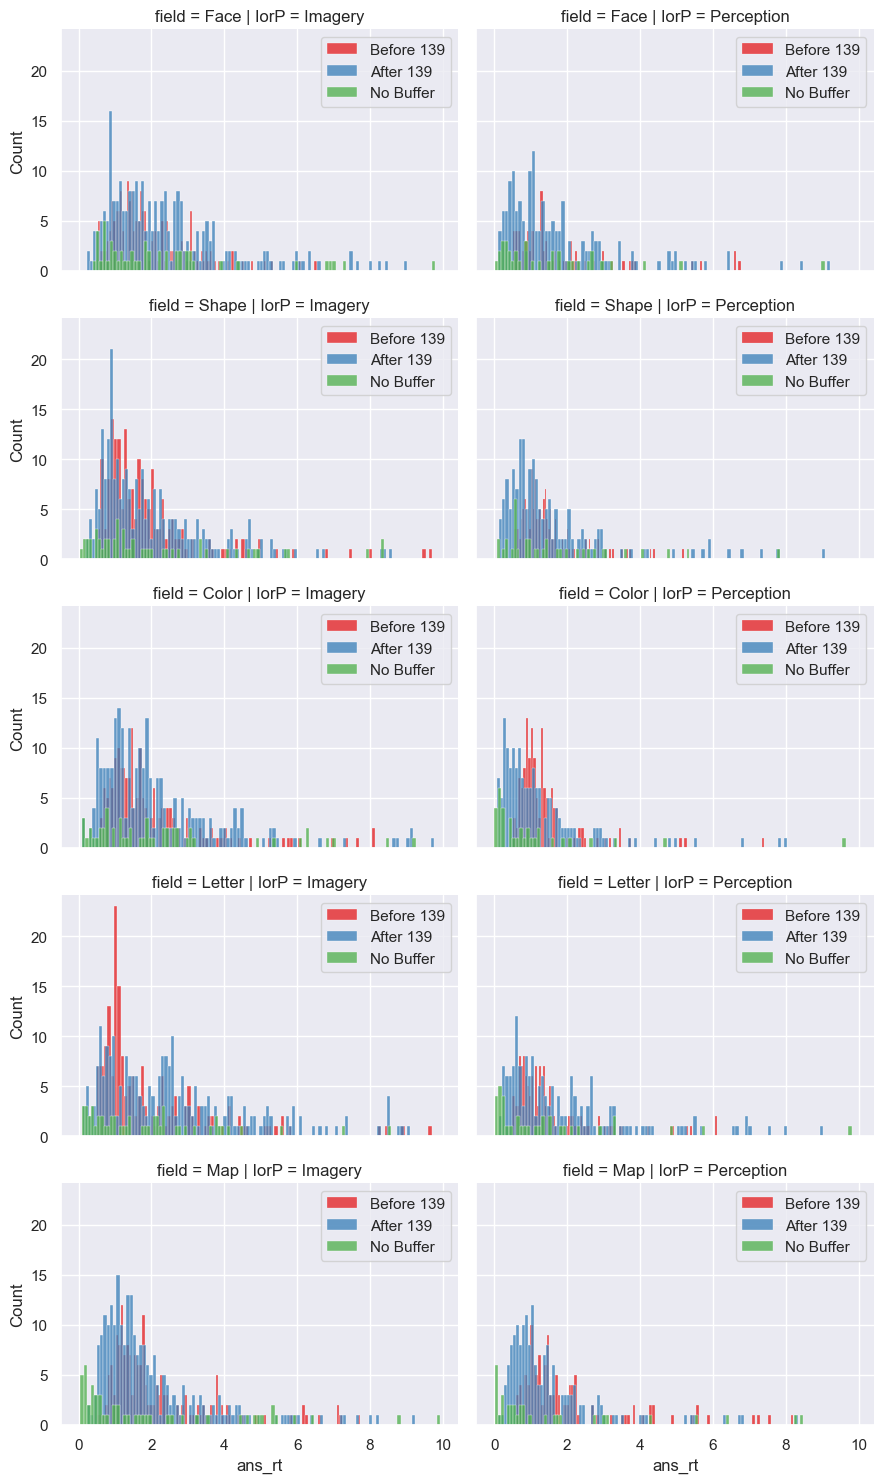

In [124]:
g = sns.FacetGrid(df_all_cut_off, row="field",  col="IorP", hue="type", palette="Set1", height = 3, aspect=1.5)
# histogram
g.map(sns.histplot, "ans_rt", bins=100)
for ax in g.axes.ravel():
    ax.legend()
plt.show()


### Statsitical Test

#### No buffer vs. before 139 rt for each task

In [125]:
df_test_before139_imagery = df_all_cut_off[(df_all_cut_off['type'] == 'Before 139') & (df_all_cut_off['IorP'] == 'Imagery')]
df_test_nobuffer_imagery = df_all_cut_off[(df_all_cut_off['type'] == 'No Buffer') & (df_all_cut_off['IorP'] == 'Imagery')]

df_test_before139_perception = df_all_cut_off[(df_all_cut_off['type'] == 'Before 139') & (df_all_cut_off['IorP'] == 'Perception')]
df_test_nobuffer_perception = df_all_cut_off[(df_all_cut_off['type'] == 'No Buffer') & (df_all_cut_off['IorP'] == 'Perception')]

In [126]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

def cal_cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def ttest_each_task(df1, df2):
    df_output = []
    word1_word2_list = df1[['word1', 'word2', 'field']].drop_duplicates().values
    for (word1, word2, field) in word1_word2_list:
        word12 = word1 + '_' + word2
        df1_tmp = df1[(df1['word1'] == word1) & (df1['word2'] == word2)]
        df2_tmp = df2[(df2['word1'] == word1) & (df2['word2'] == word2)]
        df1_rt = df1_tmp['ans_rt'].values
        df2_rt = df2_tmp['ans_rt'].values
        # t-test, variances are not equal
        t, p = ttest_ind(df1_rt, df2_rt, equal_var=False)
        mwu_p = mannwhitneyu(df1_rt, df2_rt, alternative='two-sided')[1]
        cohen_d = cal_cohen_d(df1_rt, df2_rt)
        output_tmp = {'field': field, 'word12': word12, 't': t, 'p': p, 'cohen_d': cohen_d, 'mwu_p': mwu_p}
        df_output.append(output_tmp)
    df_output = pd.DataFrame(df_output)
    return df_output

ttest_before139_nobuffer_imagery = ttest_each_task(df_test_before139_imagery, df_test_nobuffer_imagery)
ttest_before139_nobuffer_imagery[ttest_before139_nobuffer_imagery['p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
1,Face,Sarahjessicaparker_Johnnydepp,2.957064,0.017967,1.318081,0.048951
2,Face,Georgewbush_Serenawilliams,-2.645748,0.025074,-0.955825,0.121212
8,Shape,Tripod_Pan,2.925609,0.033566,1.198282,0.051282
27,Face,Juliaroberts_Sarahjessicaparker,3.427070,0.005771,1.351125,0.027972
48,Map,Lasvegas_Philadelphia,2.494695,0.047280,1.236032,0.111888
63,Color,Pomogranate_Strawberry,3.379865,0.010688,1.548252,0.027972
67,Color,Greenapple_Greenpepper,3.480578,0.006284,1.237046,0.006993
80,Map,Dallas_Boston,2.969227,0.014596,1.056776,0.006993
81,Map,Washingtondc_Seattle,3.644386,0.006386,1.623588,0.006993
83,Map,Atlanta_Minneapolis,2.718365,0.025313,1.199800,0.076923


In [127]:
# df_test_nobuffer_perception[df_test_nobuffer_perception['word1'] == 'Georgewbush']

In [128]:
ttest_before139_nobuffer_perception = ttest_each_task(df_test_before139_perception, df_test_nobuffer_perception)
ttest_before139_nobuffer_perception[ttest_before139_nobuffer_perception['mwu_p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
1,Shape,Bucket_Broom,5.772825,0.000088,2.078245,0.005495
3,Shape,Bathtub_Tripod,3.232238,0.014476,1.448238,0.021978
15,Color,Baguette_Cauliflower,5.997236,0.000402,2.617040,0.005495
18,Color,Banana_Redwine,3.241992,0.023071,1.645128,0.010989
19,Color,Lemon_Pineapple,6.127586,0.000060,2.299547,0.005495
32,Letter,Summary_Evocation,3.819456,0.020752,2.217022,0.010989
41,Map,Minneapolis_Nashville,3.155849,0.008815,1.083128,0.005495
43,Map,Lasvegas_Philadelphia,3.322515,0.010989,1.439181,0.010989
45,Map,Austin_Philadelphia,2.824329,0.016919,0.950086,0.005495
54,Face,Rihanna_Bradpitt,4.254682,0.007668,2.064464,0.023810


#### No buffer vs. after 139 rt for each task

In [129]:
df_test_after139_imagery = df_all_cut_off[(df_all_cut_off['type'] == 'After 139') & (df_all_cut_off['IorP'] == 'Imagery')]
df_test_nobuffer_imagery = df_all_cut_off[(df_all_cut_off['type'] == 'No Buffer') & (df_all_cut_off['IorP'] == 'Imagery')]

df_test_after139_perception = df_all_cut_off[(df_all_cut_off['type'] == 'After 139') & (df_all_cut_off['IorP'] == 'Perception')]
df_test_nobuffer_perception = df_all_cut_off[(df_all_cut_off['type'] == 'No Buffer') & (df_all_cut_off['IorP'] == 'Perception')]

In [130]:
ttest_after139_nobuffer_imagery = ttest_each_task(df_test_after139_imagery, df_test_nobuffer_imagery)
ttest_after139_nobuffer_imagery[ttest_after139_nobuffer_imagery['p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
13,Face,Juliaroberts_Sarahjessicaparker,3.212242,0.006081,1.028882,0.032353
22,Letter,Bad_Impression,2.444863,0.028441,0.714888,0.067647
41,Shape,Koala_Penguin,2.292984,0.047261,0.738181,0.266667
52,Color,Greenapple_Greenpepper,3.413775,0.004228,0.998808,0.120588
63,Map,Dallas_Boston,2.900544,0.011572,0.852101,0.020588
64,Map,Washingtondc_Seattle,4.067844,0.005716,1.666569,0.011765
70,Face,Kevinhart_Emmastone,3.326297,0.004877,1.069438,0.067647
73,Face,Sarahjessicaparker_Johnnydepp,2.964823,0.013161,1.044195,0.120588
89,Shape,Tripod_Pan,3.775778,0.004522,1.264024,0.038095


In [131]:
ttest_after139_nobuffer_perception = ttest_each_task(df_test_after139_perception, df_test_nobuffer_perception)
ttest_after139_nobuffer_perception[ttest_after139_nobuffer_perception['p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
1,Shape,Bucket_Broom,2.492985,0.024953,0.754314,0.244118
2,Shape,Bathtub_Tripod,2.952279,0.009896,0.913733,0.067647
12,Color,Pomogranate_Strawberry,2.625305,0.020703,0.731862,0.100000
13,Color,Baguette_Cauliflower,2.983582,0.009969,0.871454,0.020588
17,Color,Lemon_Pineapple,3.474849,0.003416,1.083255,0.002941
30,Letter,Summary_Evocation,3.186790,0.006783,1.044620,0.032353
39,Map,Minneapolis_Nashville,2.225956,0.041934,0.697921,0.047059
43,Map,Austin_Philadelphia,3.826269,0.001977,1.259876,0.020588
49,Face,Princewilliam_Berniesanders,3.569016,0.003886,1.220481,0.120588
52,Face,Rihanna_Bradpitt,2.989088,0.010272,0.862184,0.032353


#### Before 139 vs. after 139 rt for each task

In [132]:
ttest_before139_after139_imagery = ttest_each_task(df_test_before139_imagery, df_test_after139_imagery)
ttest_before139_after139_imagery[ttest_before139_after139_imagery['p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
33,Letter,Retrieve_Reject,-2.112397,0.047208,-0.790002,0.057040
52,Shape,Bathtub_Tripod,-2.305994,0.034086,-0.831225,0.065117
65,Color,Pineapple_Lemon,2.849838,0.017350,1.352273,0.004776
68,Letter,Prove_Silence,-2.099793,0.048607,-0.828668,0.077145
76,Letter,Summary_Evocation,-2.124483,0.046241,-0.791806,0.095159
87,Face,Kevinhart_Emmastone,-2.624081,0.016748,-0.965044,0.024175


In [133]:
ttest_before139_after139_percetion = ttest_each_task(df_test_before139_perception, df_test_after139_perception)
ttest_before139_after139_percetion[ttest_before139_after139_percetion['p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
4,Shape,Whiteshark_Ladybug,2.267441,0.033208,0.898226,0.058932
8,Shape,Lighter_Bowl,2.154088,0.042092,0.830367,0.017247
12,Color,Artichokes_Zucchini,3.247339,0.003703,1.305077,0.001440
14,Color,Zucchini_Guacamole,2.613212,0.019163,1.117439,0.002589
16,Color,Fig_Pumpkin,2.698720,0.013552,1.098502,0.023092
42,Map,Kansascity_Atlanta,2.272748,0.039309,0.986337,0.035059


#### Before After together vs. no buffer rt for each task

In [134]:
df_test_beforeafter_imagery = df_all_cut_off[(df_all_cut_off['type'] != 'No Buffer') & (df_all_cut_off['IorP'] == 'Imagery')]
df_test_beforeafter_perception = df_all_cut_off[(df_all_cut_off['type'] != 'No Buffer') & (df_all_cut_off['IorP'] == 'Perception')]

In [135]:
ttest_beforeafter_no_buffer_imagery = ttest_each_task(df_test_beforeafter_imagery, df_test_nobuffer_imagery)
ttest_beforeafter_no_buffer_imagery[ttest_beforeafter_no_buffer_imagery['p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
1,Face,Sarahjessicaparker_Johnnydepp,3.564687,0.010451,1.110449,0.056752
8,Shape,Tripod_Pan,4.135710,0.011431,1.170790,0.024615
27,Face,Juliaroberts_Sarahjessicaparker,4.236010,0.001064,1.116594,0.015726
36,Letter,Bad_Impression,2.563612,0.016756,0.568820,0.277607
55,Shape,Koala_Penguin,2.810340,0.031852,0.752749,0.184615
63,Color,Pomogranate_Strawberry,2.836935,0.016868,0.775892,0.045812
67,Color,Greenapple_Greenpepper,4.829685,0.000058,1.066821,0.028034
80,Map,Dallas_Boston,4.111837,0.000372,0.913655,0.004786
81,Map,Washingtondc_Seattle,4.557966,0.007551,1.631607,0.002735
87,Face,Kevinhart_Emmastone,2.938213,0.012442,0.781066,0.187350


In [136]:
ttest_beforeafter_no_buffer_perception = ttest_each_task(df_test_beforeafter_perception, df_test_nobuffer_perception)
ttest_beforeafter_no_buffer_perception[ttest_beforeafter_no_buffer_perception['p'] < 0.05]

,field,word12,t,p,cohen_d,mwu_p
1,Shape,Bucket_Broom,4.738007,0.000107,1.102368,0.050672
3,Shape,Bathtub_Tripod,3.637202,0.002686,0.918160,0.025031
13,Color,Pomogranate_Strawberry,3.980777,0.000528,0.820822,0.068376
15,Color,Baguette_Cauliflower,4.048480,0.000416,0.887527,0.004274
19,Color,Lemon_Pineapple,5.690722,0.000039,1.410502,0.000611
32,Letter,Summary_Evocation,3.909361,0.004694,1.126942,0.009768
41,Map,Minneapolis_Nashville,3.576106,0.001733,0.830753,0.009768
43,Map,Lasvegas_Philadelphia,2.964898,0.015464,0.819372,0.050672
45,Map,Austin_Philadelphia,4.025772,0.000477,0.904101,0.004274
51,Face,Princewilliam_Berniesanders,3.711224,0.002429,1.047663,0.138905


#### Without breaking down by task

In [137]:
def rt_test(df1, df2):
    df1_rt = df1['ans_rt'].values
    df2_rt = df2['ans_rt'].values
    # t-test, variances are not equal
    t, p = ttest_ind(df1_rt, df2_rt, equal_var=False)
    mwu_p = mannwhitneyu(df1_rt, df2_rt, alternative='two-sided')[1]
    cohen_d = cal_cohen_d(df1_rt, df2_rt)
    return t, p, mwu_p, cohen_d

In [138]:
df_test_before139_imagery['ans_rt'].mean(), df_test_after139_imagery['ans_rt'].mean(), df_test_nobuffer_imagery['ans_rt'].mean()

(1.9997527189249171, 2.218019288566606, 2.174592410727974)

In [139]:
df_test_before139_perception['ans_rt'].mean(), df_test_after139_perception['ans_rt'].mean(), df_test_nobuffer_perception['ans_rt'].mean()

(1.6336781123550173, 1.5991159379806812, 1.5221174429377966)

In [140]:
rt_test(df_test_after139_imagery, df_test_nobuffer_imagery)

(0.3083455210426453,
 0.7580124730757711,
 0.002005018312003843,
 0.024338217840843238)

In [141]:
rt_test(df_test_after139_perception, df_test_nobuffer_perception)

(0.5029463223837982,
 0.6154914356275045,
 0.0003015082301391028,
 0.04810119462179796)

In [142]:
rt_test(df_test_before139_imagery, df_test_nobuffer_imagery)

(-1.244860026211042,
 0.21407023626644836,
 0.014784868927980503,
 -0.10885313886604348)

In [143]:
rt_test(df_test_before139_imagery, df_test_nobuffer_perception)

(3.159341353620589,
 0.0018083449151331556,
 6.394537727747686e-16,
 0.31663224294947323)